# Imports and set up

In [1]:
# install keras packages
!pip install keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.0 MB/s eta 0:00:00


In [2]:
# necesary imports and setup

import os
import shutil

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

import time
import numpy as np
import tqdm
import cv2

np.random.seed(13)

Using TensorFlow backend


In [3]:
# assigning tags to the model's classes

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [3]:
# setting bounding box format
# stands for x,y coordinates for the edge of the box and its width and height
bbformat = "xywh"

# Functions

In [11]:
def create_resizing_layer(bbformat:str, width:int = 640, height:int = 640):
  # resizing to get an image size that is divisible by 64 to ensure compability with the downscaling done by the convolutio
  resizing_layer = keras_cv.layers.Resizing(
      width, height, pad_to_aspect_ratio=True, bounding_box_format=bbformat
  )
  return resizing_layer

In [12]:
def create_model(bbformat:str, iou_threshold:float = 0.2, confidence:float = 0.55):
  prediction_decoder = keras_cv.layers.NonMaxSuppression(
      bounding_box_format=bbformat,
      from_logits=True,
      # decrease the threshold to prune out predictions
      iou_threshold=iou_threshold,
      # go higher to display boxes with higher confidence score
      confidence_threshold=confidence,
  )
  model = keras_cv.models.YOLOV8Detector.from_preset(
      "yolo_v8_m_pascalvoc",
      bounding_box_format="xywh",
      prediction_decoder=prediction_decoder,
  )
  return model

In [13]:
def prepare_image(path, resizing_layer):
  # load image
  image = keras.utils.load_img(path)
  image = np.array(image)
  # resizing
  image = resizing_layer([image])

  return image

In [14]:
def transform_video_to_frames(video_path, image_path):

  # Target Keyframes Per Second
  KPS = 1

  EXTENSION = ".png"

  cap = cv2.VideoCapture(video_path)

  current_frame = 0

  while(True):

    ret, frame = cap.read()

    if ret:
      name = f'{image_path}frame{current_frame}{EXTENSION}'

      cv2.imwrite(name, frame)

      current_frame += 1

    else:
      break

  # release space and windows
  cap.release()
  cv2.destroyAllWindows()


In [4]:
def transform_frames_to_video(images_path, video_path, video_name):

  frames_per_second = 30

  image_list = os.listdir(images_path)

  img=[]

  for image in image_list:
      img.append(cv2.imread(f'{images_path}{image}'))

  height, width, layers=img[1].shape
  fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
  video=cv2.VideoWriter(f'{video_path}{video_name}-processed.mp4',fourcc,frames_per_second,(width,height))

  print(len(img))

  for frame in img:
      video.write(frame)

  cv2.destroyAllWindows()
  video.release()

In [37]:
def process_video(original_video_path, processed_video_path, model, resizing_layer, cleanup:bool = False):

  # turn to frames
  # create a temporary directory for frames
  video_name = original_video_path[path.rfind("/")+1:path.rfind(".")]
  shortened_path = path[:path.rfind("/")+1]
  frames_directory = f'{shortened_path}{video_name}/'
  unprocessed_frames_directory = f'{frames_directory}/unprocessed/'
  processed_frames_directory = f'{frames_directory}/processed/'

  if not os.path.exists(frames_directory):
    os.mkdir(frames_directory)
    os.mkdir(unprocessed_frames_directory)
    os.mkdir(processed_frames_directory)
    print("directories created")
  else:
    print("directory name error")
    return

  transform_video_to_frames(original_video_path, unprocessed_frames_directory)
  print(f"turned to frames {len(os.listdir(unprocessed_frames_directory))} frames")

  # analize frames
  frame_list = os.listdir(unprocessed_frames_directory)

  for frame in frame_list:
    image = prepare_image(f"{unprocessed_frames_directory}{frame}", resizing_layer)
    y_pred = model.predict(image, verbose=0)
    visualization.plot_bounding_box_gallery(
      image,
      value_range=(0, 255),
      rows=1,
      cols=1,
      y_pred=y_pred,
      scale=5,
      font_scale=0.5,
      bounding_box_format="xywh",
      class_mapping=class_mapping,
      path=f"{processed_frames_directory}{frame}"
  )

  # reasemble the video
  transform_frames_to_video(processed_frames_directory, shortened_path, video_name )
  print("video assembled")
  # cleanup

  if cleanup:
    shutil.rmtree(frames_directory)
    print("deleted files")


In [7]:
transform_frames_to_video("/content/drive/MyDrive/object_detection/videos/man-dog-fence/processed/","/content/drive/MyDrive/object_detection/videos/")

2576


# Initialization

In [18]:
resizing_layer = create_resizing_layer(bbformat)

In [20]:
model = create_model(bbformat)

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [ ]:
process_video("/content/drive/MyDrive/object_detection/videos/man-dog-fence.mp4","",model,resizing_layer)

directories created
turned to frames
1/1 [==============================] - 3s 3s/step


# old reliable


In [5]:
# referencing local test files
files_dir = '/content/drive/MyDrive/object_detection/test-images/'
files = os.listdir(files_dir)

image shape = (855, 1340, 3)
image shape = (1, 640, 640, 3)


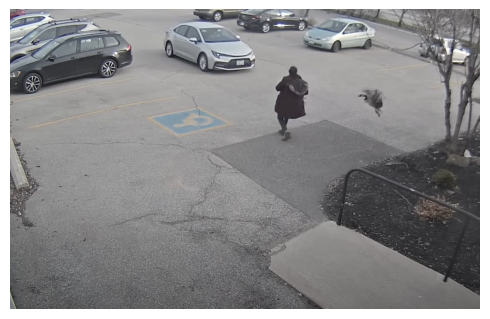

In [6]:
# loading image
image = keras.utils.load_img(f'{files_dir}{files[0]}')
image = np.array(image)



visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0,255),
    rows=1,
    cols=1,
    scale=5
)

print(f'image shape = {image.shape}')

# resizing to get an image size that is divisible by 64 to ensure compability with the downscaling done by the convolutions

resizing_layer = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

image = resizing_layer([image])


print(f'image shape = {image.shape}')

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1/1 [==============================] - 13s 13s/step
done


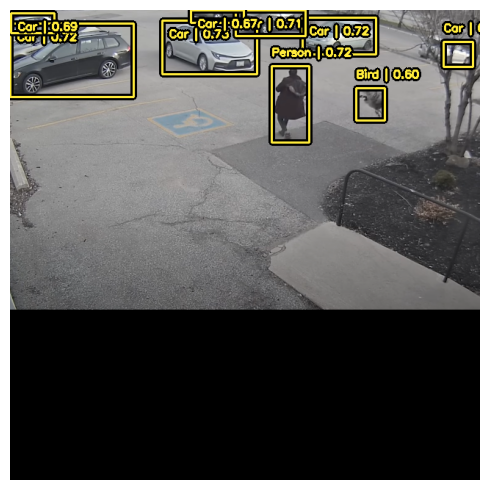

In [9]:
# NonMaxSuppression layer used to reduce the Intersection over Union (IOU)
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # decrease the threshold to prune out predictions
    iou_threshold=0.2,
    # go higher to display boxes with higher confidence score
    confidence_threshold=0.55,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image)
visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.5,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
    path=f"{files_dir}test.png"
)
print('done')

In [10]:
visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.5,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
    path=f"{files_dir}test.png"
)

In [8]:
keras.utils.save_img(f"{files_dir}test.png",y_pred)

TypeError: float() argument must be a string or a real number, not 'dict'

In [ ]:
transform_to_frames("/content/drive/MyDrive/object_detection/fox-snow.mp4", "/content/drive/MyDrive/object_detection/video-frames/")

In [ ]:
transform_to_video("/content/drive/MyDrive/object_detection/video-frames/", "/content/drive/MyDrive/object_detection/")

326
